In [1]:
from tf_data_split import split_and_prepare_datasets

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [5]:
facial_keypoints_train_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/sobel_facial_keypoints_train_dataset.tfrecord", compression="GZIP")
facial_keypoints_test_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_test_dataset.tfrecord", compression="GZIP")

In [6]:
print(f'info train data: {facial_keypoints_train_dataset_loaded}')
print(f'number of train data: {len(facial_keypoints_train_dataset_loaded)}')
print()
print(f'info test data: {facial_keypoints_test_dataset_loaded}')
print(f'number of test data: {len(facial_keypoints_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
number of train data: 14098

info test data: <_LoadDataset element_spec=TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None)>
number of test data: 1783


=======================Check Train Data======================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 1.0
    min intensity: 1.2183098974105633e-10

    keypoint: [66.67694118 33.94122353 30.71364706 36.14950588 60.36705882 35.20312941
 71.724      33.31030588 36.70729412 36.46496471 24.08894118 36.14950588
 59.42117647 29.84018824 77.08729412 27.63197647 38.916      31.41755294
 17.97741176 30.75515294 49.32635294 60.44047059 64.46823529 72.42776471
 35.76141176 73.05882353 50.27223529 71.79670588 50.58776471 82.52258824]
    keypoint-shape: (30,)
    image-type: float64
    max-value: 82.5225882353
    min-value: 17.9774117647


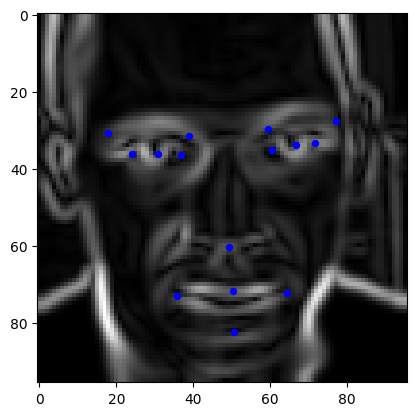

In [8]:
for img, keypoint in facial_keypoints_train_dataset_loaded.skip(16).take(1).as_numpy_iterator():
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}

    keypoint: {keypoint}
    keypoint-shape: {keypoint.shape}
    image-type: {keypoint.dtype}
    max-value: {tf.reduce_max(keypoint)}
    min-value: {tf.reduce_min(keypoint)}'''
    )

    for i in range(0, len(keypoint), 2):
        x = keypoint[i]
        y = keypoint[i+1]
        plt.scatter(x, y, s=75, marker='.', c='blue')
    plt.imshow(img, cmap='gray')
plt.show()

=======================Check Test Data=======================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 0.9686274528503418
    min intensity: 0.007843137718737125


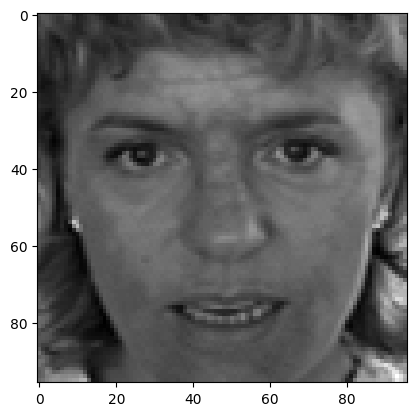

In [9]:
for img in facial_keypoints_test_dataset_loaded.skip(1).take(1).as_numpy_iterator():
    print(f"{'Check Test Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}'''
    )
    plt.imshow(img, cmap='gray')
plt.show()

In [10]:
train_dataset_batched, valid_dataset_batched = split_and_prepare_datasets(facial_keypoints_train_dataset_loaded, batch_size=64, train_split=0.9, shuffle_buffer_size=None)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
Training Split: 0.9
Number of data: 12688
AFTER BATCH: 64
Number of data: 199
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
Validation Split: 0.1
Number of data: 1410
AFTER BATCH: 64
Number of data: 23


In [11]:
# Fungsi masked loss
def masked_mse_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)  # Masker untuk nilai yang tidak nol (keypoint yang tersedia)
    mask = tf.cast(mask, tf.float32)  # Konversi ke float
    loss = tf.square(y_true - y_pred) * mask  # Hitung MSE hanya pada keypoint yang tersedia
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Rata-rata loss berdasarkan jumlah keypoint yang tersedia
    return loss

# Fungsi untuk membuat blok residual dengan konvolusi strided
def residual_block(x, filters):
    residual = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', strides=2)(x)
    residual = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', strides=2)(residual)
    x = tf.keras.layers.add([x, residual])
    return x

# Arsitektur ML-ResNet
def create_ml_resnet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Lapisan pertama
    x = tf.keras.layers.Conv2D(32, (11, 11), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Blok residual pertama
    x = residual_block(x, 64)

    # Blok residual kedua
    x = residual_block(x, 128)

    # Lapisan akhir
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(30)(x)  # 15 keypoints dengan masing-masing x dan y koordinat

    model = tf.keras.models.Model(inputs, x)
    return model

learning_rate_adam = tf.keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

# Membuat dan mengkompilasi model
input_shape = (96, 96, 1)
model = create_ml_resnet(input_shape)
model.compile(optimizer=learning_rate_adam, loss=masked_mse_loss)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      3,904 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │      8,320 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 12,    │          0 │ conv2d_5[0][0],   │
│                     │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18432)     │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1000)      │ 18,433,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │     30,030 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,754,230 (71.54 MB)

 Trainable params: 18,754,230 (71.54 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
target_path_keras_model = './Assets/facial-keypoints-detection-model/facial_keypoints_detection_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=target_path_keras_model,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True,
  verbose=1
)

history = model.fit(
    train_dataset_batched,
    validation_data=valid_dataset_batched,
    epochs=250,
    callbacks=[
    plateau_callback,
    early_stopping,
    checkpoint_callback
  ]
)

In [14]:
# Evaluasi model yang dimuat
loaded_evaluation = model.evaluate(valid_dataset_batched)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

In [15]:
idx = np.random.randint(0, len(valid_dataset_batched))

plt.figure(figsize=(10,5))
for image, keypoint in valid_dataset_batched.skip(idx).take(1):
  image = image = tf.expand_dims(image[0], axis=0)
  keypoint = keypoint[0]

  pred_keypoints = model.predict(image)
  pred_keypoints = tf.squeeze(pred_keypoints)

  plt.subplot(1, 2, 1)
  plt.imshow(image[0], cmap='gray')
  plt.title('original')
  # Loop through pairs of labels (x, y)
  for i in range(0, len(keypoint), 2):
    x = keypoint[i].numpy()
    y = keypoint[i+1].numpy()
    plt.scatter(x, y, s=200, marker='.', c='blue')

  plt.subplot(1, 2, 2)
  plt.imshow(image[0], cmap='gray')
  plt.title('prediction')
  # Loop through pairs of labels (x, y)
  for i in range(0, len(pred_keypoints), 2):
    x = pred_keypoints[i].numpy()
    y = pred_keypoints[i+1].numpy()
    plt.scatter(x, y, s=200, marker='.', c='blue')

plt.show()